## Importing Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import models, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import CSVLogger

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30
SEED = 42
VAL_SPLIT = 0.2
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Loading & Train Validation Split

In [4]:
train_ds = image_dataset_from_directory(
    "data",
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    validation_split = VAL_SPLIT,
    subset = "training",
    shuffle = True,
    seed = SEED,
)
val_ds = image_dataset_from_directory(
    "data",
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    validation_split = VAL_SPLIT,
    subset = "validation",
    shuffle = True,
    seed = SEED,
)

Found 16011 files belonging to 10 classes.
Using 12809 files for training.
Found 16011 files belonging to 10 classes.
Using 3202 files for validation.


### Further split into validation dataset and test data set

In [5]:
val_split = 0.5 
val_ds_size = len(val_ds)
val_size = int(val_split * val_ds_size)

test_ds = val_ds.take(val_size)
val_ds = val_ds.skip(val_size)

In [6]:
print(f"Number of training batches: {len(train_ds)}")
print(f"Number of validatiing batches: {len(val_ds)}")
print(f"Number of testing batches: {len(test_ds)}")

Number of training batches: 401
Number of validatiing batches: 51
Number of testing batches: 50


In [7]:
class_names = train_ds.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

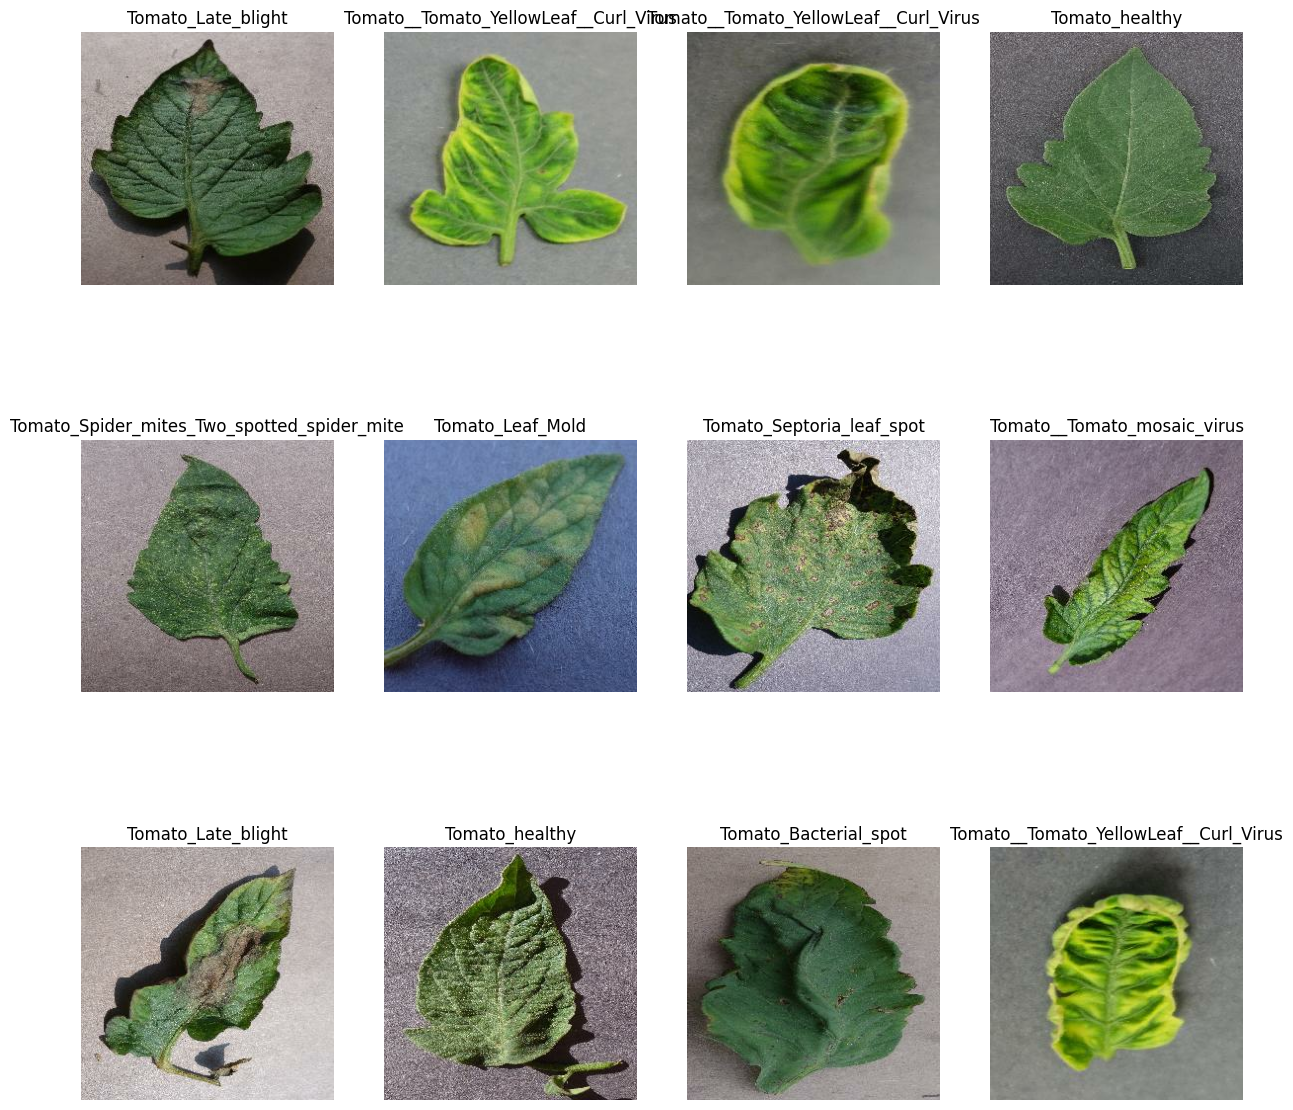

In [8]:
plt.figure(figsize = (15, 15))
for image_batch, label_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

## Optimize the performance of input pipelines

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    preprocessing.Rescaling(1.0 / 255)
])

## Data Augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomContrast(0.3)
])

## Model Building

In [12]:
n_classes = len(class_names)
n_classes

10

In [13]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=INPUT_SHAPE)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('training3.log')

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping, csv_logger]
)

Epoch 1/30
401/401 [==============================] - 136s 288ms/step - loss: 1.8943 - accuracy: 0.3151 - val_loss: 1.4967 - val_accuracy: 0.4407
Epoch 2/30
401/401 [==============================] - 115s 286ms/step - loss: 1.4499 - accuracy: 0.4927 - val_loss: 1.1902 - val_accuracy: 0.5581
Epoch 3/30
401/401 [==============================] - 105s 261ms/step - loss: 1.1549 - accuracy: 0.6010 - val_loss: 0.9606 - val_accuracy: 0.6648
Epoch 4/30
401/401 [==============================] - 103s 256ms/step - loss: 0.9472 - accuracy: 0.6780 - val_loss: 0.9252 - val_accuracy: 0.6816
Epoch 5/30
401/401 [==============================] - 103s 258ms/step - loss: 0.8281 - accuracy: 0.7174 - val_loss: 1.1414 - val_accuracy: 0.6623
Epoch 6/30
401/401 [==============================] - 104s 259ms/step - loss: 0.7391 - accuracy: 0.7526 - val_loss: 0.9862 - val_accuracy: 0.6904
Epoch 7/30
401/401 [==============================] - 104s 259ms/step - loss: 0.6269 - accuracy: 0.7941 - val_loss: 0.5545 -

Epoch 16/30
401/401 [==============================] - 104s 259ms/step - loss: 0.3225 - accuracy: 0.8952 - val_loss: 0.3913 - val_accuracy: 0.8808
Epoch 17/30
401/401 [==============================] - 104s 260ms/step - loss: 0.3037 - accuracy: 0.9023 - val_loss: 0.2348 - val_accuracy: 0.9238
Epoch 18/30
401/401 [==============================] - 104s 259ms/step - loss: 0.2902 - accuracy: 0.9046 - val_loss: 0.2850 - val_accuracy: 0.9039
Epoch 19/30
401/401 [==============================] - 103s 258ms/step - loss: 0.2598 - accuracy: 0.9141 - val_loss: 0.4719 - val_accuracy: 0.8714
Epoch 20/30
401/401 [==============================] - 103s 256ms/step - loss: 0.2680 - accuracy: 0.9130 - val_loss: 0.5132 - val_accuracy: 0.8327
Epoch 21/30
401/401 [==============================] - 104s 259ms/step - loss: 0.2458 - accuracy: 0.9221 - val_loss: 0.2226 - val_accuracy: 0.9332
Epoch 22/30
401/401 [==============================] - 103s 257ms/step - loss: 0.2402 - accuracy: 0.9222 - val_loss: 0

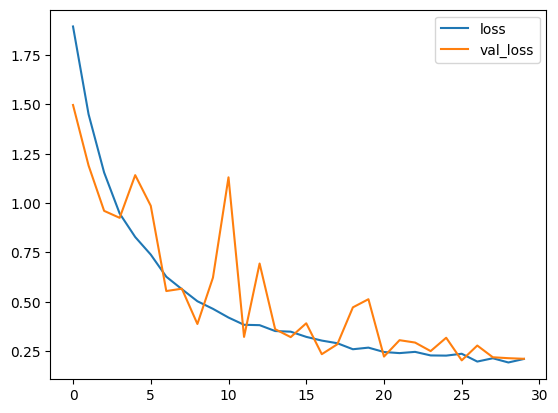

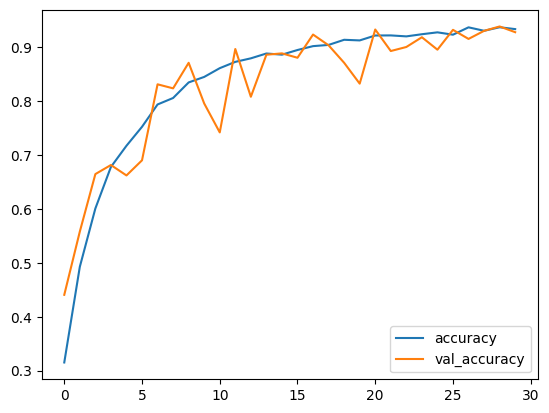

In [18]:
# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [19]:
def evaluate_model(model, test_ds):
    eval_dict = model.evaluate(test_ds, return_dict=True)
    
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())])
    
    return display_df

In [22]:
results = evaluate_model(model, test_ds)

results.head()

50/50 [==============================] - 1s 22ms/step - loss: 0.2162 - accuracy: 0.9294


loss  accuracy
0  0.216225  0.929375

first image to predict
actual label: Tomato_Bacterial_spot
1/1 [==============================] - 0s 28ms/step
predicted label: Tomato_Bacterial_spot


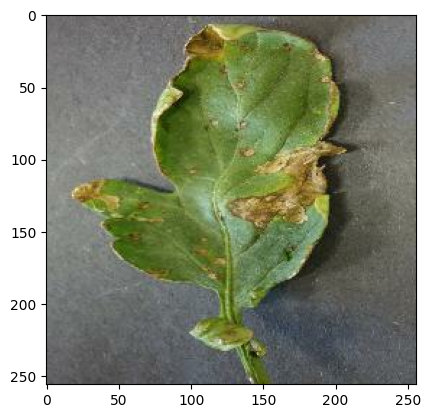

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


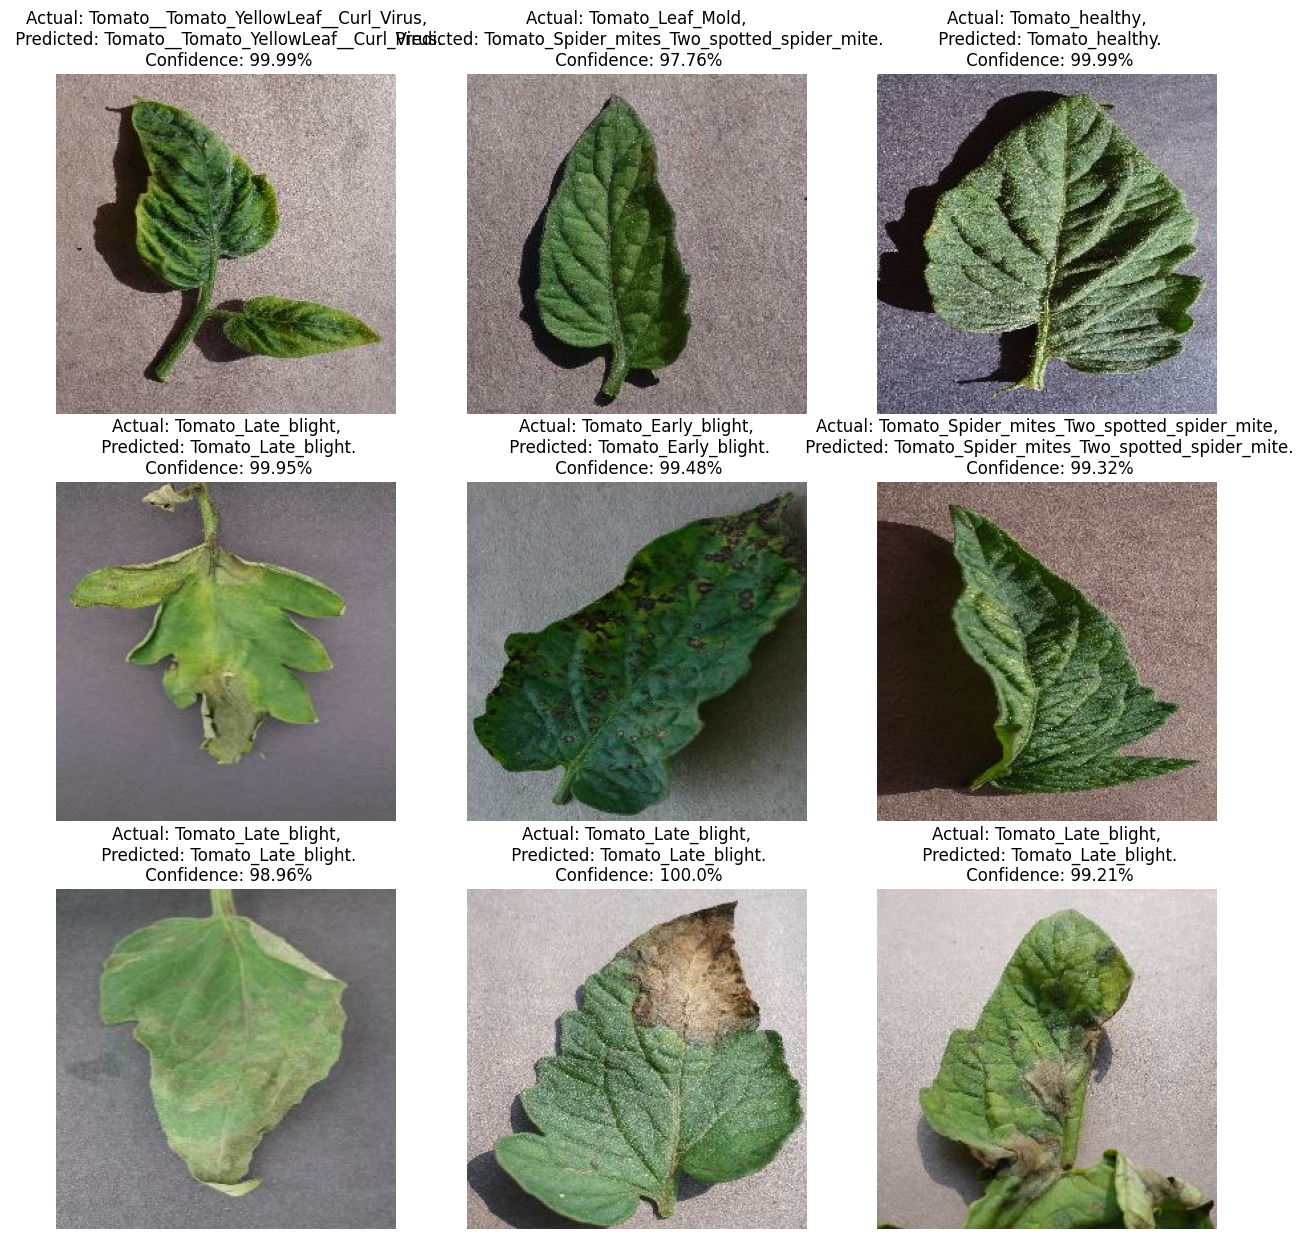

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [36]:
import os
model_version = max([int(i) for i in os.listdir("models") + [0]]) + 1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets
